In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def parse_data_from_file(filename):
    
    times = []
    UV = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        
        reader = csv.reader(csvfile, delimiter=",")
        next(reader)
        for row in reader:
            times.append(row[0])
            UV.append(float(row[1]))
        ### END CODE HERE
            
    return times,UV

In [4]:
@dataclass
class G:
    UV_CSV = '/content/drive/Shareddrives/Capstone Project/Machine Learning/Data/Dataset/KEPRI-TanjungPinang.csv'

    times , UV = parse_data_from_file(UV_CSV)
    time = np.array(times)
    series = np.array(UV)
    split_time = int(0.7*len(series))
    window_size = 24
    batch_size = 12
    shuffle_buffer_size = 1000


In [5]:
with open(G.UV_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

time,uv_index ()

First data point looks like this:

2022-08-05T00:00,0

Second data point looks like this:

2022-08-05T01:00,0



In [6]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

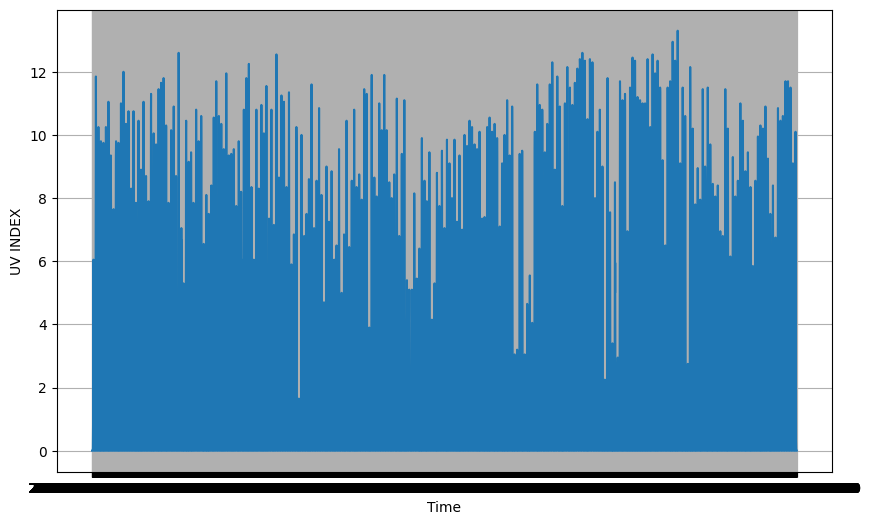

In [7]:
plot_series(G.time, G.series, xlabel='Time', ylabel='UV INDEX')

# Processing the data

In [8]:
def train_val_split(time, series, time_step=G.split_time):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.time, G.series)

In [9]:
def windowed_dataset(series, window_size=G.window_size, batch_size=G.batch_size, shuffle_buffer=G.shuffle_buffer_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-window_size:]))  # Modify the mapping function to include the last 24 timesteps
    ds = ds.batch(batch_size).prefetch(1)
    return ds



# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.window_size, batch_size=G.batch_size, shuffle_buffer=G.shuffle_buffer_size)

# Apply the transformation to the validation set
valid_set = windowed_dataset(series_valid, window_size=G.window_size, batch_size=G.batch_size, shuffle_buffer=G.shuffle_buffer_size)

In [10]:
 def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=[G.window_size, 1]),
      tf.keras.layers.LSTM(128),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(G.window_size)
    ])


    
    ### END CODE HERE

    return model

In [11]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=50, callbacks=[lr_schedule])
    
    return history

In [12]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/50
392/392 [==============================] - 17s 36ms/step - loss: 1.7746 - mae: 2.0011 - lr: 1.0000e-04
Epoch 2/50
392/392 [==============================] - 13s 34ms/step - loss: 1.7695 - mae: 1.9923 - lr: 1.1220e-04
Epoch 3/50
392/392 [==============================] - 14s 34ms/step - loss: 1.7647 - mae: 1.9864 - lr: 1.2589e-04
Epoch 4/50
392/392 [==============================] - 14s 34ms/step - loss: 1.7602 - mae: 1.9833 - lr: 1.4125e-04
Epoch 5/50
392/392 [==============================] - 13s 32ms/step - loss: 1.7556 - mae: 1.9818 - lr: 1.5849e-04
Epoch 6/50
392/392 [==============================] - 13s 33ms/step - loss: 1.7507 - mae: 1.9806 - lr: 1.7783e-04
Epoch 7/50
392/392 [==============================] - 13s 34ms/step - loss: 1.7453 - mae: 1.9795 - lr: 1.9953e-04
Epoch 8/50
392/392 [==============================] - 14s 35ms/step - loss: 1.7395 - mae: 1.9781 - lr: 2.2387e-04
Epoch 9/50
392/392 [==============================] - 13s 34ms/step - loss: 1.7331 - mae

(0.0001, 10.0, 0.0, 10.0)

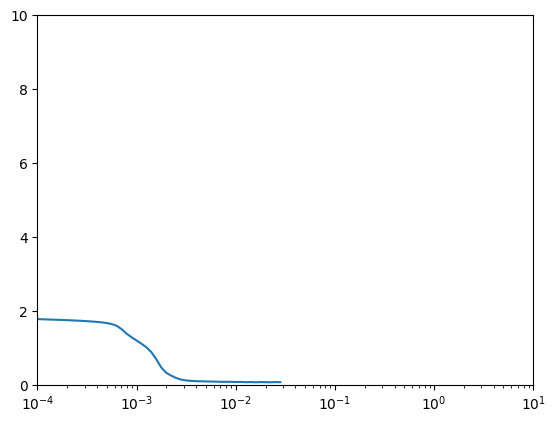

In [13]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [14]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=5e-2, momentum=0.9),
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [15]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=20,validation_data=valid_set)

Epoch 1/20
392/392 [==============================] - 20s 44ms/step - loss: 0.6075 - mae: 0.9062 - val_loss: 0.1921 - val_mae: 0.4508
Epoch 2/20
392/392 [==============================] - 15s 39ms/step - loss: 0.1373 - mae: 0.3507 - val_loss: 0.1210 - val_mae: 0.3291
Epoch 3/20
392/392 [==============================] - 16s 40ms/step - loss: 0.0963 - mae: 0.2790 - val_loss: 0.0855 - val_mae: 0.2666
Epoch 4/20
392/392 [==============================] - 15s 39ms/step - loss: 0.0903 - mae: 0.2667 - val_loss: 0.0726 - val_mae: 0.2463
Epoch 5/20
392/392 [==============================] - 18s 46ms/step - loss: 0.0824 - mae: 0.2518 - val_loss: 0.0697 - val_mae: 0.2447
Epoch 6/20
392/392 [==============================] - 15s 39ms/step - loss: 0.0737 - mae: 0.2329 - val_loss: 0.0555 - val_mae: 0.2090
Epoch 7/20
392/392 [==============================] - 18s 45ms/step - loss: 0.0704 - mae: 0.2259 - val_loss: 0.0577 - val_mae: 0.2126
Epoch 8/20
392/392 [==============================] - 16s 40ms

In [16]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae


In [17]:
def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast
    

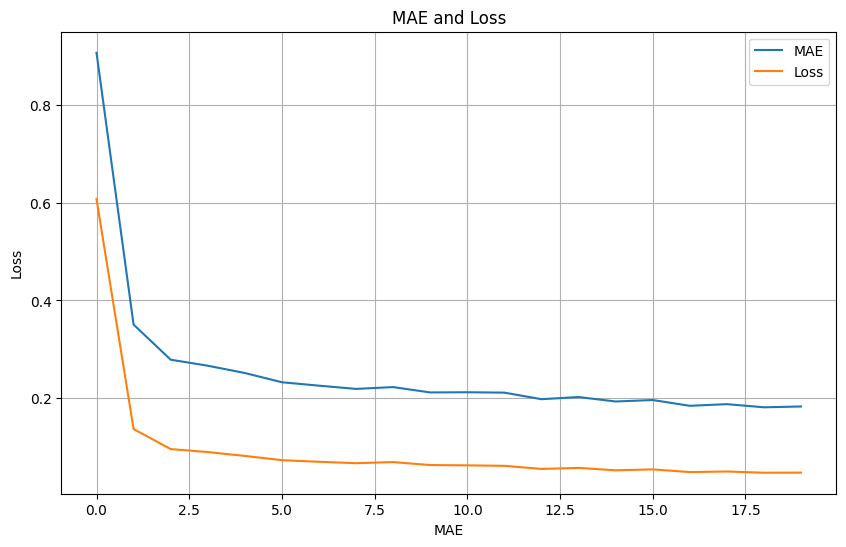

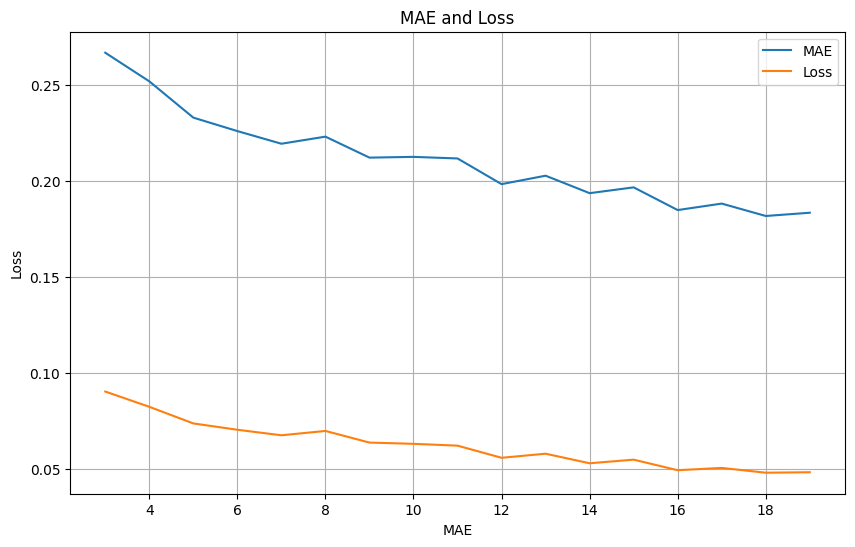

In [18]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']


# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

169/169 [==============================] - 3s 12ms/step


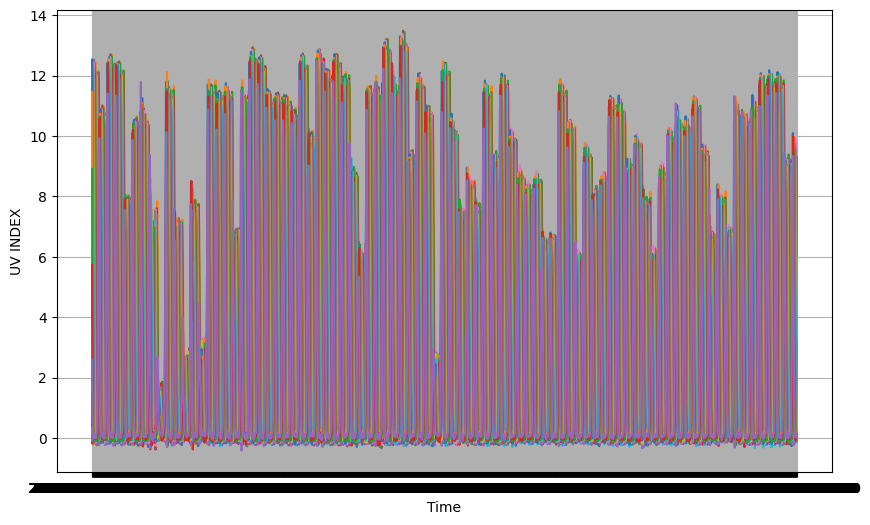

In [19]:
# Reduce the original series
forecast_series = G.series[G.split_time - G.window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, G.window_size, G.batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(G.time[G.split_time:], (G.series[G.split_time:], results), xlabel='Time', ylabel='UV INDEX')


167/167 [==============================] - 2s 12ms/step


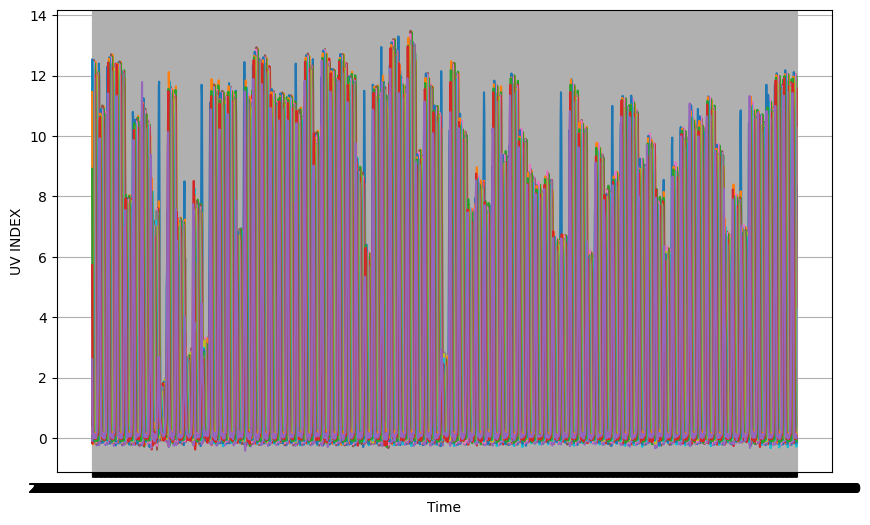

In [20]:
# Reduce the original series
forecast_series = G.series[G.split_time - G.window_size : -24]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, G.window_size, G.batch_size)

# Remove the last 24 timesteps from the forecast results
forecast = forecast[:-24]

# Trim the true series to match the dimensions of the forecast
true_series = G.series[G.split_time + G.window_size + 1 : G.split_time + G.window_size + 1 + len(forecast)]

# Plot the results
plot_series(
    G.time[G.split_time + G.window_size + 1 : G.split_time + G.window_size + 1 + len(forecast)],
    (true_series, forecast),
    xlabel='Time',
    ylabel='UV INDEX'
)


In [21]:
forecast_adjusted = forecast[:, 0]
mse, mae = compute_metrics(true_series, forecast_adjusted)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1.73, mae: 0.57 for forecast


In [22]:
import pandas as pd

tess = pd.DataFrame(data=(forecast_adjusted,true_series))

In [23]:
tess

,0,1,2,3,4,5,6,7,8,9,...,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976
0,0.52402,0.065541,0.017,-0.096963,-0.086128,-0.032518,-0.035126,-0.014635,0.07239,0.012929,...,1.764962,0.23602,0.134453,-0.044643,-0.083114,-0.039147,-0.027518,-0.027386,-0.027459,0.0539
1,0.55000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.800000,0.35000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000


In [24]:
model.save('/content/drive/Shareddrives/Capstone Project/Machine Learning/MODEL/PB/KEPRI-TanjungPinang') 

In [25]:
import h5py
model.save('/content/drive/Shareddrives/Capstone Project/Machine Learning/MODEL/H5/KEPRI-TanjungPinang.h5')

In [26]:
input_data = np.array([0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,1.95,4.55,7.55,9.90,10.70,9.50,5.95,3.65,1.60,0.30,0.00,0.00,0.00,0.00,0.00,0.00])

In [27]:
reshaped_data = input_data.reshape(1, 24, 1)
print(reshaped_data.shape)

(1, 24, 1)


In [28]:
predictions = model.predict(reshaped_data)

1/1 [==============================] - 1s 555ms/step


In [29]:
predictions

array([[ 3.11241001e-02, -6.32570088e-02, -7.13640004e-02,
        -1.00735605e-01, -3.13790143e-02,  1.22366816e-01,
         6.54904544e-01,  2.08160353e+00,  4.67780304e+00,
         7.90014648e+00,  1.03706303e+01,  1.08295174e+01,
         9.05664062e+00,  6.12466717e+00,  3.44261909e+00,
         1.35185564e+00,  2.38554299e-01, -9.47837830e-02,
         3.65355611e-03,  2.14425772e-02,  6.47346079e-02,
        -6.02101535e-02,  2.63508260e-02,  8.13822448e-02]], dtype=float32)

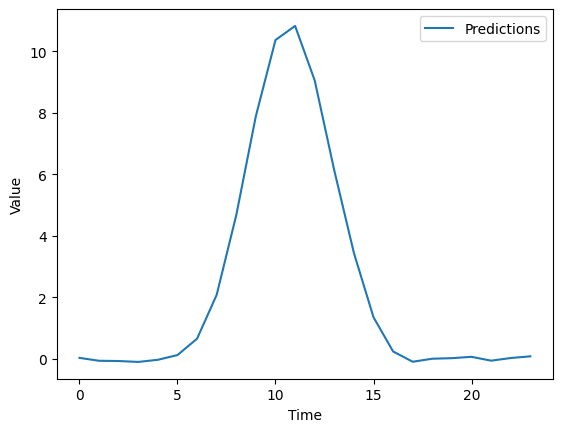

In [30]:
plt.plot(predictions.flatten(), label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()